<a href="https://colab.research.google.com/github/shadialameddin/tensor_decomposition/blob/master/tensor_decomposition_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://tensorly.org/stable/auto_examples/index.html#general-examples

https://github.com/tensorly/tensorly


Sparse backend

Kruskal-tensors have been renamed cp_tensors

Matrix-product-state has now been renamed tensor-train


In [ ]:
!pip install -U tensorly --quiet

In [ ]:
import os 

In [ ]:
if not os.path.exists('tensor_decomposition') and not os.path.isfile('TensorDecomp.py'):
    !git clone https://github.com/shadialameddin/tensor_decomposition.git --quiet

In [ ]:
%cd tensor_decomposition

In [1]:
from TensorDecomp import *
import matplotlib.pyplot as plt
from read_h5 import *

list of available decomposition types:

decomp_list = ['svd', 'parafac', 'tucker', 'matrix_product_state', 'NMF','non_negative_parafac', 'clarkson_woodruff_transform']
#### The Error Handles

In [2]:
err_fro  = lambda  x, y : norm(x-y, ord='fro') / norm(x, ord='fro')
err_L1   = lambda  x, y : norm(x-y, ord=1) / norm(x, ord=1)
err_Linf = lambda  x, y : norm(x-y, ord=inf) / norm(x, ord=inf)
err_Spec = lambda  x, y : norm(x-y, ord=2) / norm(x, ord=2)
    
normL = [err_fro, err_L1, err_Linf, err_Spec]

### Scene Setup

In [3]:
# the tensor of interest 
number_of_phases, material_index, weights, truncated_strain_modes, singular_values = load_reduced_basis(file_name='data/laminate_sphere.h5', number_of_modes=64)

tensor = np.einsum('...k,k->...k', truncated_strain_modes, singular_values, optimize='optimal')
ngp, d, N = tensor.shape

#ngp, d, N = 312,32,128
#tensor = np.random.rand(ngp,d,N)

print("The tensor dimension:\t",tensor.shape)

# two derived matrices of the tensor (unfolding)
mat_repr1_tens = tensor.reshape(-1, N)
mat_repr2_tens = tensor.reshape(ngp,-1)

# a vector with appropriate dimension to perform operations
vec = np.random.rand(N)

# a matrix with appropriate dimensions to perform operations
someMatrix = np.random.rand(ngp, d)

# a tensor with appropriate dimensions to perform operations
someTensor = np.random.rand(ngp, d, d)

### Some Tensor Operations ###

# tensor x some vector
tensVec = tensor@vec

# tensor x some matrix
tensMat = np.einsum('ilk,il->k', tensor, someMatrix, optimize='optimal')

# tensor x some tensor x tensor
tensTenstens = np.einsum('ilk,ilm,imp->kp', tensor, someTensor, tensor, optimize='optimal')

# matrix representation of a tensor x some vector
matRepr1Vec = mat_repr1_tens@vec

# matrix representation of tensor x some matrix
matRepr1Mat = mat_repr1_tens.T@someMatrix.flatten()

# matrix representations of a tensor x some tensor x matrix representations of a tensor
matReprTensMatRepr = mat_repr1_tens.T @ blk_diag(someTensor) @ mat_repr1_tens

### TIME MEASUREMENT OF TENSOR OPERATIONS ###
n = 1000

# time of tensor x some vector
time_tensVec = timeit.timeit( lambda: tensor@vec, number = n)/n

# time of tensor x some matrix
time_tensMat = timeit.timeit(lambda:np.einsum('ilk,il->k', tensor, someMatrix, optimize='optimal'), number = n)/n

# time of tensor x some other tensor x tensor
time_tensTenstens = timeit.timeit( lambda:np.einsum('ilk,ilm,imp->kp', tensor, someTensor, tensor, optimize='optimal'), number = n)/n

# time of matrix representation of a tensor x some vector
time_matRepr1Vec = timeit.timeit( lambda: mat_repr1_tens@vec, number = n)/n

# time of matrix representations of a tensor x some tensor x matrix representations of a tensor
bsr = blk_diag(someTensor)
time_matReprTensMatRepr = timeit.timeit( lambda:mat_repr1_tens.T @ bsr @ mat_repr1_tens, number = n)/n

# time of matrix representation of tensor x some matrix
flattedMat = someMatrix.flatten()
time_matRepr1Mat = timeit.timeit( lambda: mat_repr1_tens.T@flattedMat, number = n)/n

done reading h5 file
The tensor dimension:	 (8744, 6, 64)


# SVD

In [4]:
svd_rank = 6
u, s, vt = svds(mat_repr1_tens, svd_rank)
print(u.shape,s.shape,vt.shape)

(52464, 6) (6,) (6, 64)


### Decomposition Time

In [5]:
n = 20
svdDecTime = timeit.timeit((lambda: svds(mat_repr1_tens, svd_rank)), number=n)/n
print("Average SVD Decomposition Time:\t", svdDecTime)

Average SVD Decomposition Time:	 0.14999433999999995


### Memory Saving

In [6]:
memSavSvd = (tensor.nbytes - sum(f.nbytes for f in [u,s,vt])) / tensor.nbytes
print(f"Memory saving with SVD using {svd_rank} Rank:\t", memSavSvd)

Memory saving with SVD using 6 Rank:	 0.9061338489249772


### Decomposition Error

In [7]:
mat_repr1_recons = u @ np.diag(s) @ vt
svdFro, svdL1, svdLinf, svdSpec = [error(mat_repr1_tens, mat_repr1_recons) for error in normL ]

print("Frobenius Norm of the SVD Decomposition Error:\t", svdFro)
print("L1 Norm of the SVD Decomposition Error:\t\t", svdL1)
print("L infinity Norm of the SVD Decomposition Error:\t", svdLinf)
print("Spectral Norm of the SVD Decomposition Error:\t", svdSpec)

svdError = [svdFro, svdL1, svdLinf,svdSpec]

Frobenius Norm of the SVD Decomposition Error:	 0.4111777280694063
L1 Norm of the SVD Decomposition Error:		 0.325093383261072
L infinity Norm of the SVD Decomposition Error:	 0.5775008026743985
Spectral Norm of the SVD Decomposition Error:	 0.3045628245544942


### Error in Decomposed Tensor Operations

In [8]:
# svd of matrix representation of tensor x some vector
svdMatReprVec = u @ (np.diag(s) @ (vt @ vec))

# svd of matrix representation of tensor x some matrix
svdMatReprMat = vt.T @ np.diag(s) @ ( u.T @ someMatrix.flatten())

# svd of matrix representation of tensor x some Tensor x svd of matrix representation of tensor
svdMatReprTenssvdMatRepr = vt.T @ np.diag(s) @ ( u.T @ bsr @ u) @ np.diag(s) @ vt

svdDecVec_fro, svdDecVec_L1, svdDecVec_Linf, svdDecVec_L2 = [norm(tensVec,svdMatReprVec.reshape(tensVec.shape)) for norm in normL]
print(svdDecVec_fro, svdDecVec_L1, svdDecVec_Linf, svdDecVec_L2)

tensMat_svdMatReprMat_L2 = err_Spec(tensMat,svdMatReprMat)
print(tensMat_svdMatReprMat_L2)

svdMatReprTenssvdMatRepr_tensTenstens_fro, svdMatReprTenssvdMatRepr_tensTenstens_L1, svdMatReprTenssvdMatRepr_tensTenstens_Linf, svdMatReprTenssvdMatRepr_tensTenstens_L2 = [norm(tensTenstens,svdMatReprTenssvdMatRepr) for norm in normL]
print(svdMatReprTenssvdMatRepr_tensTenstens_fro, svdMatReprTenssvdMatRepr_tensTenstens_L1, svdMatReprTenssvdMatRepr_tensTenstens_Linf, svdMatReprTenssvdMatRepr_tensTenstens_L2)

0.3837646061913742 0.4060298617160444 0.36104507573956734 0.33685165708539716
0.6284265008724096
0.20338650483971382 0.23437262601183267 0.23337940895772202 0.11485825635924429


### Decomposition Speed Up Measures in Tensor Operations

In [9]:
# time of svd of matrix representation of tensor x some vector
time_svdMatReprVec = timeit.timeit( lambda:u @ (np.diag(s) @ (vt @ vec)), number = n)/n

# time of svd of matrix representation of tensor x some matrix
time_svdMatReprMat = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ flattedMat), number = n)/n

# time of svd of matrix representation of tensor x some Tensor x svd of matrix representation of tensor x some
time_svdMatReprTenssvdMatRepr = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ bsr @ u) @ np.diag(s) @ vt, number = n)/n

# Speed up in operations

### 
speedup_tensVec_matReprVec = time_tensVec / time_matRepr1Vec
speedup_matRepr1Vec_svdMatReprVec =  time_matRepr1Vec / time_svdMatReprVec
speedup_tensVec_svdMatReprVec = time_tensVec / time_svdMatReprVec

###
speedup_tensMat_matRepr1Mat = time_tensMat / time_matRepr1Mat
speedup_matRepr1Mat_svdMatReprMat = time_matRepr1Mat / time_svdMatReprMat
speedup_tensMat_svdMatReprMat = time_tensMat / time_svdMatReprMat

###
speedup_tenstenstens_matReprTensMatRepr = time_tensTenstens / time_matReprTensMatRepr
speedup_matReprTensMatRepr_svdMatReprTenssvdMatRepr = time_matReprTensMatRepr / time_svdMatReprTenssvdMatRepr 
speedup_tenstenstens_svdMatReprTenssvdMatRepr = time_tensTenstens / time_svdMatReprTenssvdMatRepr 

print(speedup_tensVec_matReprVec, speedup_matRepr1Vec_svdMatReprVec, speedup_tensVec_svdMatReprVec)
print(speedup_tensMat_matRepr1Mat, speedup_matRepr1Mat_svdMatReprMat, speedup_tensMat_svdMatReprMat)
print(speedup_tenstenstens_matReprTensMatRepr, speedup_matReprTensMatRepr_svdMatReprTenssvdMatRepr, speedup_tenstenstens_svdMatReprTenssvdMatRepr )

1.4747941718795132 7.897961275917265 11.647867259452866
1.167656094049635 16.888642284389704 19.720126083591985
1.488041797868805 5.969946581352623 8.883530044096682


# Tucker Decomposition

In [10]:
rank_tucker = (6,6,6)
core, factors = tucker(tensor, rank_tucker)
print("Core Dimension:\t\t",core.shape)
print("Factors Dimensions:\t", [f.shape for f in factors])

Core Dimension:		 (6, 6, 6)
Factors Dimensions:	 [(8744, 6), (6, 6), (64, 6)]


### Decomposition Time

In [11]:
n = 10
tuckerDecTime = timeit.timeit((lambda: tucker(tensor, rank_tucker)), number=n)/n
print("Average Tucker Decomposition Time:\t", tuckerDecTime)

Average Tucker Decomposition Time:	 0.5300747400000005


### Memory Saving

In [12]:
memSavTucker = (tensor.nbytes - (core.nbytes + sum(f.nbytes for f in factors))) / tensor.nbytes
print(f"Memory saving with Tucker Decomposition using {rank_tucker} Rank:\t", memSavTucker)

Memory saving with Tucker Decomposition using (6, 6, 6) Rank:	 0.9841855844007319


### Decomposition Error

In [13]:
tensor_approx_tucker = np.einsum('lmn,il,jm,kn->ijk',core,factors[0],factors[1],factors[2])
tuckerFro, tuckerL1, tuckerLinf, tuckerSpec = [error(tensor.reshape(-1,N), tensor_approx_tucker.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the Tucker Decomposition Error:\t", tuckerFro)
print("L1 Norm of the Tucker Decomposition Error:\t\t", tuckerL1)
print("L infinity Norm of the Tucker Decomposition Error:\t", tuckerLinf)
print("Spectral Norm of the Tucker Decomposition Error:\t", tuckerSpec)

tuckerError = [tuckerFro, tuckerL1, tuckerLinf, tuckerSpec]

Frobenius Norm of the Tucker Decomposition Error:	 0.6288289642879412
L1 Norm of the Tucker Decomposition Error:		 0.5519039730420082
L infinity Norm of the Tucker Decomposition Error:	 0.8860094949709493
Spectral Norm of the Tucker Decomposition Error:	 0.5640353508223318


### Decomposed Tensor Operations

In [14]:
# decomposed tensor @ vec
tuckerTens_Vec = np.einsum('klm,pk,rl,s->pr', core, factors[0], factors[1], factors[2].T @ vec)

# decomposed tensor @ mat
tuckerTens_Mat = np.einsum('klm,pk,pl,rm->r', core, (someMatrix.T@factors[0]), factors[1], factors[2])

# decomposed tensor @ someTensor @ decomposed tensor
# tuckerTens_tensor_tuckerTens = np.einsum( ,optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [15]:
tuckerTensVec_fro, tuckerTensVec_L1, tuckerTensVec_Linf, tuckerTensVec_L2 = [error(tensVec, tuckerTens_Vec ) for error in normL]

print(tuckerTensVec_fro, tuckerTensVec_L1, tuckerTensVec_Linf, tuckerTensVec_L2)

tuckerTensMat_L2 = err_Spec(tensMat, tuckerTens_Mat) 

print(tuckerTensMat_L2)

#tuckerTensTens_fro, tuckerTensTens_L1, tuckerTensTens_Linf, tuckerTensTens_L2 = [error(tensTenstens, d) for error in normL]
#print(tuckerTensTens_fro, tuckerTensTens_L1, tuckerTensTens_Linf, tuckerTensTens_L2)

1.3079992345706914 1.2382926828832734 1.1029750410557393 1.1608104097086056
0.7449993500193911


### Decomposition Speed Up Measures in Tensor Operations

In [16]:
n = 100

# time of tucker tensor x some vector
time_tuckerTens_Vec = timeit.timeit(lambda:np.einsum('klm,pk,rl,s->pr', core, factors[0], factors[1], factors[2].T @ vec, optimize ='optimal'), number = n)/n

# time of tucker tensor x some matrix
time_tuckerTens_Mat = timeit.timeit( lambda:np.einsum('klm,pk,pl,rm->r', core, (someMatrix.T@factors[0]), factors[1], factors[2],optimize ='optimal'), number = n)/n

# time of tucker tensor x some Tensor x tucker tensor
#time_parTens_tensor_parTens = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ blk_diag(someTensor) @ u) @ np.diag(s) @ vt, number = n)/n

In [17]:
speedUP_tensVec_tuckerTensVec = time_tensVec / time_tuckerTens_Vec
speedUP_tensMat_tuckerTensMat = time_tensMat / time_tuckerTens_Mat
#speedUP_tensTensortens_parTensTensorParTens = time_tensTenstens / time_time_parTens_tensor_parTens

print(speedUP_tensVec_tuckerTensVec,speedUP_tensMat_tuckerTensMat)

4.081055389387792 2.9879188767022216


# Parafac Decomposition

In [18]:
rank_parafac = 6
weight, factors = parafac(tensor, rank_parafac)

print("Parafac weight dimension:\t",weight.shape)
print("Parafac factors dimension:\t", [f.shape for f in factors])

Parafac weight dimension:	 (6,)
Parafac factors dimension:	 [(8744, 6), (6, 6), (64, 6)]


### Decomposition Time

In [19]:
n = 20
parDecTime = timeit.timeit((lambda: parafac(tensor, rank_parafac)), number=n)/n
print("Average Parafac Decomposition Time:\t", parDecTime)

Average Parafac Decomposition Time:	 13.364541380000002


### Memory Saving

In [20]:
parMemSav = (tensor.nbytes - (weight.nbytes + sum(f.nbytes for f in factors))) / tensor.nbytes
print(f"Memory saving with Parafac using {rank_parafac} Rank:\t", parMemSav)

Memory saving with Parafac using 6 Rank:	 0.9842481272872827


### Decomposition Error

In [21]:
tensor_approx_parafac = np.einsum('il,jl,kl->ijk',(factors[0]*weight),factors[1],factors[2])
parFro, parL1, parLinf, parSpec = [error(tensor.reshape(-1,N), tensor_approx_parafac.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the Parafac Decomposition Error:\t", parFro)
print("L1 Norm of the Parafac Decomposition Error:\t\t", parL1)
print("L infinity Norm of the Parafac Decomposition Error:\t", parLinf)
print("Spectral Norm of the Parafac Decomposition Error:\t", parSpec)

parafacError = [parFro,parL1,parLinf,parSpec]

Frobenius Norm of the Parafac Decomposition Error:	 0.649230348259399
L1 Norm of the Parafac Decomposition Error:		 0.5769081483992029
L infinity Norm of the Parafac Decomposition Error:	 0.9502458725846876
Spectral Norm of the Parafac Decomposition Error:	 0.6092171013380203


### Decomposed Tensor Operations

In [22]:
# decomposed tensor @ vec
parTens_Vec = np.einsum('il,jl,l->ij',(factors[0]*weight),factors[1],factors[2].T @ vec)

# decomposed tensor @ mat
parTens_Mat = np.einsum('k,mk,mk,ok->o', weight, someMatrix.T@factors[0], factors[1], factors[2])


# decomposed tensor @ someTensor @ decomposed tensor
#parTens_tensor_parTens = np.einsum( optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [23]:
parTensVec_fro, parTensVec_L1, parTensVec_Linf, parTensVec_L2 = [error(tensVec, parTens_Vec ) for error in normL]

print(parTensVec_fro, parTensVec_L1, parTensVec_Linf, parTensVec_L2)

parTensMat_L2 = err_Spec(tensMat, parTens_Mat) 

print(parTensMat_L2)

#parTensTens_fro, parTensTens_L1, parTensTens_Linf, parTensTens_L2 = [error(tensTenstens, parTensTens) for error in normL]

0.6482586009685699 0.6294938027187568 0.7219396823715208 0.5079731371746586
0.7229465109169088


### Decomposition Speed Up Measures in Tensor Operations

In [24]:
n=100

# time of Parafac tensor x some vector
time_parTens_Vec = timeit.timeit(lambda:np.einsum('il,jl,l->ij',(factors[0]*weight),factors[1],factors[2].T @ vec, optimize ='optimal'), number = n)/n

# time of Parafac tensor x some matrix
time_parTens_Mat = timeit.timeit( lambda:np.einsum('k,mn,op->o', ((someMatrix.T@factors[0])@weight), factors[1], factors[2],optimize ='optimal'), number = n)/n

# time of Parafac tensor x some Tensor x Parafac tensor
#time_parTens_tensor_parTens = timeit.timeit( )/n

In [25]:
speedUP_tensVec_parTensVec = time_tensVec / time_parTens_Vec
speedUP_tensMat_parTensMat = time_tensMat / time_parTens_Mat
#speedUP_tensTensortens_parTensTensorParTens = time_tensTenstens / time_time_parTens_tensor_parTens

print(speedUP_tensVec_parTensVec,speedUP_tensMat_parTensMat)

6.661384735510297 6.367815328050693


# Tensor Train (matrix product state)

In [26]:
rank_tt = 6
factors = matrix_product_state(tensor, (1,rank_tt,rank_tt,1))
print("Tensor Train factors dimension:\t", [f.shape for f in factors])

Tensor Train factors dimension:	 [(1, 8744, 6), (6, 6, 6), (6, 64, 1)]


### Decomposition Time

In [27]:
n = 50
ttDecTime = timeit.timeit((lambda: matrix_product_state(tensor, (1,rank_tt,rank_tt,1))), number=n)/n
print("Average Tensor Train Decomposition Time:\t", ttDecTime)

Average Tensor Train Decomposition Time:	 0.039115606000000296


### Memory Saving

In [28]:
memSavTT = (tensor.nbytes - sum(f.nbytes for f in factors)) / tensor.nbytes
print(f"Memory saving with Tensor Train Decomposition using {rank_tt} Rank:\t", memSavTT)

Memory saving with Tensor Train Decomposition using 6 Rank:	 0.9841963060384263


### Decomposition Error

In [29]:
tensor_approx_tt = np.einsum('nil,ljm,mkn->ijk',factors[0],factors[1],factors[2])
ttFro, ttL1, ttLinf, ttSpec = [error(tensor.reshape(-1,N), tensor_approx_tt.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the Tensor Train Decomposition Error:\t\t", ttFro)
print("L1 Norm of the Tensor Train Decomposition Error:\t\t", ttL1)
print("L infinity Norm of the Tensor Train Decomposition Error:\t", ttLinf)
print("Spectral Norm of the Tensor Train Decomposition Error:\t\t", ttSpec)

ttError = [ttFro, ttL1, ttLinf, ttSpec]

Frobenius Norm of the Tensor Train Decomposition Error:		 0.6307608199446076
L1 Norm of the Tensor Train Decomposition Error:		 0.5604461258438658
L infinity Norm of the Tensor Train Decomposition Error:	 0.911630116052108
Spectral Norm of the Tensor Train Decomposition Error:		 0.5770307500749138


### Decomposed Tensor Operations

In [30]:
# decomposed tensor @ vec
ttTens_Vec = (factors[0].reshape(-1, factors[0].shape[-1])) @ (factors[1]@(factors[2].reshape(-1,factors[2].shape[1]) @ vec))
# decomposed tensor @ mat
someMatrix.T@factors[0].reshape(-1,factors[0].shape[-1])
ttTens_Mat = np.einsum('bc,cbc,cde->d',someMatrix.T@factors[0].reshape(-1,factors[0].shape[-1]), factors[1], factors[2])

# decomposed tensor @ someTensor @ decomposed tensor
#tuckerTens_tensor_tuckerTens = np.einsum( optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [31]:
ttTensVec_fro, ttTensVec_L1, ttTensVec_Linf, ttTensVec_L2 = [error(tensVec, ttTens_Vec ) for error in normL]

print(ttTensVec_fro, ttTensVec_L1, ttTensVec_Linf, ttTensVec_L2)

ttTensMat_L2 = err_Spec(tensMat,ttTens_Mat)
print(ttTensMat_L2)

#parTensTens_fro, parTensTens_L1, parTensTens_Linf, parTensTens_L2 = [error(tensTenstens, parTensTens) for error in normL]

0.6525438624377919 0.7944907837624486 0.7315440114712188 0.5871982157239831
1.0271615964113687


### Decomposition Speed Up Measures in Tensor Operations

In [32]:
n=100

# time of tt tensor x some vector
time_ttTens_Vec = timeit.timeit(lambda: (factors[0].reshape(-1, factors[0].shape[-1])) @ (factors[1]@(factors[2].reshape(-1,factors[2].shape[1]) @ vec)), number = n)/n

# time of tt tensor x some matrix
time_ttTens_Mat = timeit.timeit(lambda: np.einsum('bc,cbc,cde->d',someMatrix.T@factors[0].reshape(-1,factors[0].shape[-1]), factors[1], factors[2], optimize = 'optimal'), number = n)/n

# time of tt tensor x some Tensor x tucker tensor
#time_ttTens_tensor_ttTens = timeit.timeit( )

In [33]:
speedUP_tensVec_ttTensVec = time_tensVec / time_ttTens_Vec
speedUP_tensMat_ttTensMat = time_tensMat / time_ttTens_Mat
#speedUP_tensTensortens_ttTensTensorParTens = time_tensTenstens / time_ttTens_tensor_ttTens

print(speedUP_tensVec_ttTensVec, speedUP_tensMat_ttTensMat)

7.111303661697271 2.874094241573456


# PLOTS

 ## Bar plot for error, time, memory saving (among the decomposition types)

In [34]:
import matplotlib.ticker as mtick
%matplotlib inline
nameAxis = ['SVD '+f'\n(Rank: {svd_rank})', 'Tucker '+f'\n(Rank: {rank_tucker})', 'Parafac '+f'\n(Rank: {rank_parafac})', 'Tensor Train '+f'\n(Rank: {rank_tt})' ]
decErrAxis = [100*svdFro, 100*tuckerFro, 100*parFro, 100*ttFro]
decTimeAxis = [svdDecTime, tuckerDecTime, parDecTime, ttDecTime]
memSavAxis = [100*memSavSvd, 100*memSavTucker, 100*parMemSav, 100*memSavTT ]


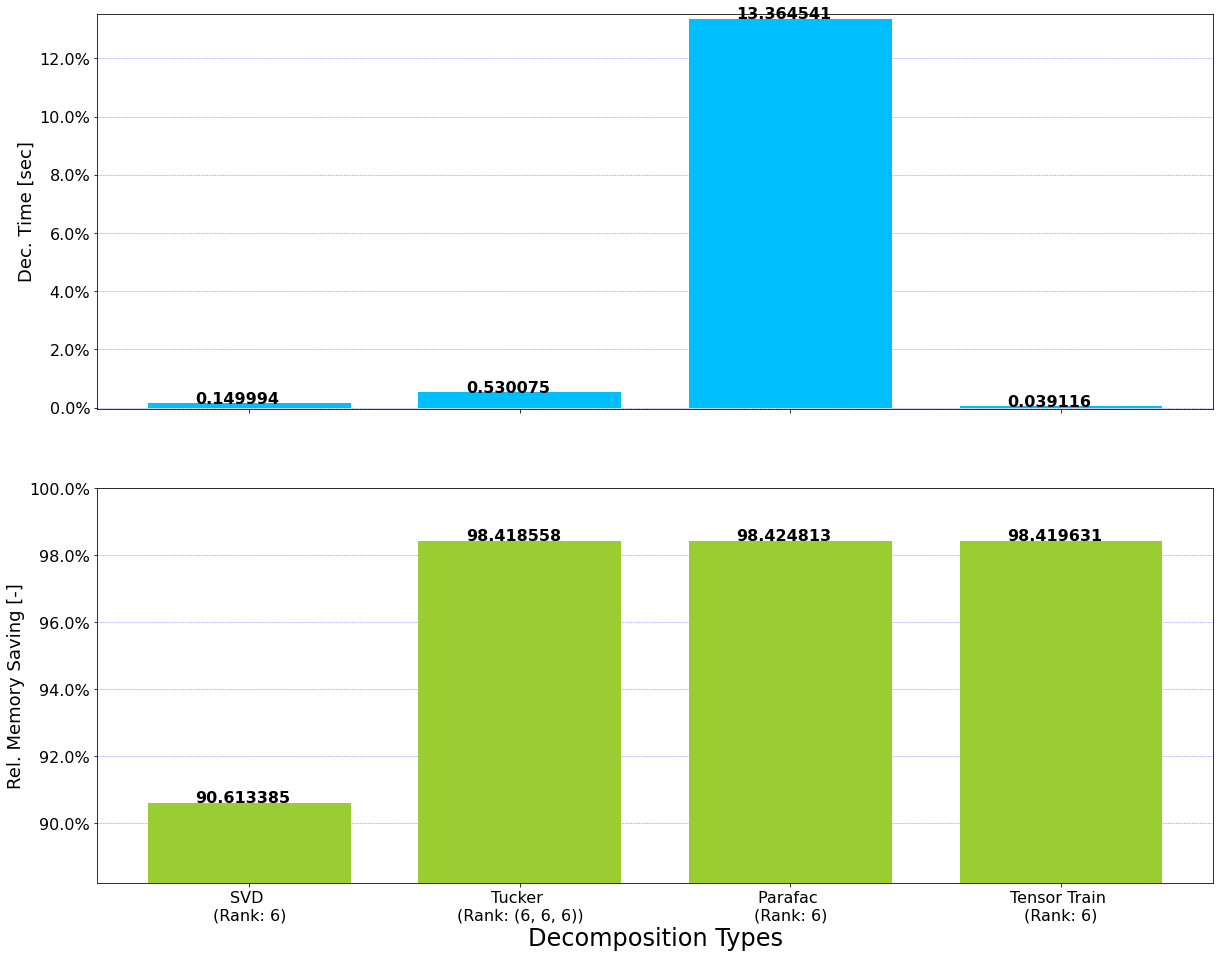

In [35]:
colors = ["deepskyblue", "yellowgreen"]
y_axis = [decTimeAxis, memSavAxis ]
fig, ax = plt.subplots(2, 1, figsize=(20,16), sharex=True)

for i in range(2):
    ax[i].bar(nameAxis, y_axis[i], color=colors[i], width = .75)
    ax[i].yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    ax[i].set_axisbelow(True)
    ax[i].set_ylim(min(y_axis[i])- np.mean(y_axis[i])*0.025, max(y_axis[i])+ np.mean(y_axis[i])*0.05)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    for h, v in enumerate(y_axis[i]):
        ax[i].text(h-.20, v+.0025, str(np.round(v,6)), color='black', size = 16, weight = "bold")

plt.xlabel("Decomposition Types", fontsize=24)

ax[0].set_ylabel("Dec. Time [sec]", fontsize=18)
ax[1].set_ylabel("Rel. Memory Saving [-]", fontsize=18)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_ylim(min(y_axis[i])- np.mean(y_axis[i])*0.025, 100)
plt.savefig('fig/SavTimeError.png')

In [ ]:
from matplotlib import ticker
uniSlightBlue = '#00BEFF'
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.bar(operList, tensorOperationTimes, color = uniSlightBlue)
ax.yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xticks(rotation=22.5)
ax.set_axisbelow(True)
ax.set_ylabel("Elapsed Time [sec]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

In [ ]:
#TODO #1
# Speed comparion is not implemented. No function definition is defined for decomposed_tensor @ Vec multiplication.

In [ ]:
#TODO #2
# For every decomposition type -> Line Plot: operation error, speedup time in tensor operations vs decomposed tensor operations.

In [ ]:
# DONE! (11.07.21)
# For every decomposition type -> Bar plot: Decomposition error, decomposition time, memory saving